# Problema do Caixeiro Viajante (Traveling Salesman Problem)


### Libraries Needed

In [102]:
import geopy.distance
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [103]:
np.random.seed(4)

## Criação do Dataset

In [123]:
## Funções para criarem coordenadas e distâncias
def give_me_coordinates(start_lat, start_lon, max_delta):  
    """Gera coordenadas geográficas aleatórias:
    
     Parâmetros:
    - start_lat: coordenadas latitudinais iniciais (float)
    - start_lon: coordenadas longitudinais iniciais (float)
    - max_delta: desvio máximo permitido para gerar coordenadas a partir das coordenadas latitudinais e longitudinais iniciais.
    
    Return: par de coordenadas geográficas aleatórias (latitude e longitude)
    """        
    
    lat = start_lat + np.random.rand() * max_delta
    lon = start_lon + np.random.rand() * max_delta
    
    return (lat, lon)
    
def give_me_distance(start, end, var = 1):
    """Calcula a distância geodésica entre dois pontos e adiciona um pequeno valor aleatório.
    
    Parâmetros:
    - start: coordenadas do ponto inicial (tuple)
    - end: coordenadas do ponto final (tuple)
    - var: valor aleatório adicionado à distância.
    
    Return: Distância geodésica com valor aleatório adicionado em quilómetros.
    """
    d = geopy.distance.geodesic(start, end).km
    return d * (1+np.random.randn()/10)

def create_tsp(number_of_cities, start_lat, start_lon, max_delta = 2):
    """ Cria uma matriz de distâncias entre cidades.
    
    Parâmetros:
    - number_of_cities: número de cidades (int)
    - start_lat: latitude inicial 
    - start_lon: longitude inicial
    - max_delta: desvio máximo permitido para gerar coordenadas aleatórias.
    
    Returns: Matriz de distância entre as cidades.
    """
    
    city_locations = [give_me_coordinates(start_lat, start_lon, max_delta) for _ in range(number_of_cities)]
    total_distances = []
    for start in city_locations:
        distances = []
        for finish in city_locations:
            distances.append(give_me_distance(start, finish))
        total_distances.append(distances)
    return total_distances
        

In [124]:
# criar variável 'distances' com 10 cidades, latitude inicial = 50 e longitude inicial = 20.
distances = create_tsp(10,50,20)


## Função Objectivo (Sugestão)

In [125]:
# Criação de lista com ordem das cidades para iniciar a função
solucao_candidata = np.random.choice(10, 10, replace=False)

In [126]:
def objective_function(distances,solucao_candidata):
    """ Calcula a função objetivo para a solução candidata.
    
    Parâmetros: 
    distances:Matriz de distância entre as cidades (list)
    solucao_candidata: lista com ordem das cidades inicial
    
    Returns: valor da função objetivo para a solução candidata.
    """
    last_city = solucao_candidata[0]
    total_distance = 0
    for city in solucao_candidata:
        total_distance += distances[last_city][city]
        last_city = city
    total_distance += distances[last_city][solucao_candidata[0]] # por ultimo regressamos à cidade original
    return total_distance

In [127]:
objective_function(distances, solucao_candidata)

996.9895678634743

## Simulated Annealing

#### Pergunta 1. 
Codifica um algoritmo capaz de fazer uma procura pelo ótimo global.

In [128]:
#sugestão vizinhança 1
def generate_neighbour(solution):
    """Gera um vizinho a partir da troca de duas cidades na solução candidata.
    
    Parâmetros: 
    - solution: lista com solução candidata (list)
    
    Returns: Lista com cidades com troca de duas cidades a partir da solução candidata inicial.
    """
    # Implementa uma perturbação simples na solução trocando duas cidades de posição
    neighbour = solution.copy()
    idx1, idx2 = np.random.choice(len(solution), size=2, replace=False)
    neighbour[idx1], neighbour[idx2] = neighbour[idx2], neighbour[idx1]
    return neighbour

In [129]:
def simulated_annealing(distances, initial_solution, initial_temperature, cooling_rate, num_iterations):
    """ Algoritmo que utiliza simullate annealing para encontrar solução ótima num Problema do Caixeiro Viajante.

    Parâmetros:
    - distances: Matriz de distâncias entre as cidades. (list)
    - initial_solution: solução candidata inicial (list)
    - initial_temperature: Temperatura inicial (float)
    - cooling_rate: Taxa de arrefecimento (float)
    - num_iterations (int): Número de iterações a serem realizadas.

    Returns: Melhor solução para o algoritmo. (list)
    """
    current_solution = initial_solution
    best_solution = current_solution
    temperature = initial_temperature

    for iteration in range(num_iterations):
        neighbour_solution = generate_neighbour(current_solution)
        current_cost = objective_function(distances, current_solution)
        neighbour_cost = objective_function(distances, neighbour_solution)

        if neighbour_cost < current_cost or np.random.rand() < np.exp((current_cost - neighbour_cost) / temperature):
            current_solution = neighbour_solution

        if neighbour_cost < objective_function(distances, best_solution):
            best_solution = neighbour_solution

        temperature *= cooling_rate

    return best_solution

In [130]:
# Exemplo de uso
num_cities = 10
start_lat, start_lon = 50, 20
max_delta = 2

city_locations = [give_me_coordinates(start_lat, start_lon, max_delta) for _ in range(num_cities)]
distances = [[give_me_distance(city_locations[i], city_locations[j]) for j in range(num_cities)] for i in range(num_cities)]

initial_solution = np.random.permutation(num_cities)
initial_temperature = 1000.0
cooling_rate = 0.95
num_iterations = 20000

best_solution = simulated_annealing(distances, initial_solution, initial_temperature, cooling_rate, num_iterations)
best_distance = objective_function(distances, best_solution)

print("Melhor solução:", best_solution)
print("Distância da melhor solução:", best_distance)

Melhor solução: [3 4 0 1 7 6 9 5 8 2]
Distância da melhor solução: 464.1437936111567


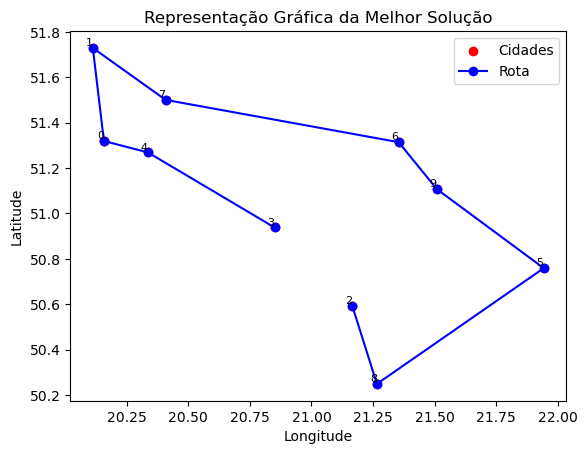

In [131]:
# Função para fazer plot das cidades e da rota com a melhor solução:
def plot_solution(city_locations, solution):
    # Descompacta as coordenadas das cidades
    lats, lons = zip(*city_locations)
    
    # Adiciona a primeira cidade no final para fechar o ciclo
    lats += (lats[0],)
    lons += (lons[0],)
    
    # Plota as cidades
    plt.scatter(lons, lats, color='red', marker='o', label='Cidades')
    
    # Plota a rota
    plt.plot(np.take(lons, solution), np.take(lats, solution), linestyle='-', marker='o', color='blue', label='Rota')
    
    # Adiciona rótulos para as cidades
    for i, txt in enumerate(range(len(city_locations))):
        plt.annotate(txt, (lons[i], lats[i]), fontsize=8, ha='right', va='bottom')
    
    # Adiciona legendas e títulos
    plt.legend()
    plt.title('Representação Gráfica da Melhor Solução')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Exibe o gráfico
    plt.show()

# Exemplo de uso
plot_solution(city_locations, best_solution)

#### Pergunta 2. 
Testa várias combinações de Temperatura Inicial e de método de atualização de Temperatura, e comenta sobre o impacto que esta atualização e valor tem no resultado final do modelo.

In [132]:
def run_sa_experiments(distances, initial_solution, initial_temperatures, cooling_rates, num_iterations):
    """ Experimenta várias combinações de temperatura inicial e de método de atualização da mesma.

    Parâmetros:
    - distances: Matriz de distâncias entre as cidades. (list)
    - initial_solution: Solução candidata inicial. (list)
    - initial_temperatures: lista de temperaturas iniciais. (list)
    - cooling_rates: Lista de taxas de arrefecimento. (list)
    - num_iterations: Número de iterações. (int)

    Returns: Lista com resultados.
    """
    results = []

    for initial_temp in initial_temperatures:
        for cooling_rate in cooling_rates:
            # Executa o Simulated Annealing para uma combinação específica de temperatura inicial e taxa de arrefecimento
            best_solution = simulated_annealing(distances, initial_solution, initial_temp, cooling_rate, num_iterations)
            best_distance = objective_function(distances, best_solution)

            # Armazena os resultados
            results.append({
                'initial_temp': initial_temp,
                'cooling_rate': cooling_rate,
                'best_solution': best_solution,
                'best_distance': best_distance
            })

    return results

# Configurações
initial_temperatures = [10000, 5000, 1000]
cooling_rates = [0.95, 0.98, 0.99]
num_iterations = 10000

# Executa experiências
experiment_results = run_sa_experiments(distances, initial_solution, initial_temperatures, cooling_rates, num_iterations)

# Imprime os resultados
for result in experiment_results:
    print(f"Initial_temperature {result['initial_temp']}, Colling Rate: {result['cooling_rate']}")
    print(f"Melhor Solução: {result['best_solution']}")
    print(f"Distância da Melhor Solução: {result['best_distance']}")
    print("\n")

Initial_temperature 10000, Colling Rate: 0.95
Melhor Solução: [8 2 4 0 9 6 1 7 3 5]
Distância da Melhor Solução: 587.1597224900997


Initial_temperature 10000, Colling Rate: 0.98
Melhor Solução: [9 6 4 0 1 7 3 2 8 5]
Distância da Melhor Solução: 468.863062139674


Initial_temperature 10000, Colling Rate: 0.99
Melhor Solução: [6 4 0 1 7 3 2 8 5 9]
Distância da Melhor Solução: 468.863062139674


Initial_temperature 5000, Colling Rate: 0.95
Melhor Solução: [0 1 7 6 9 5 8 2 3 4]
Distância da Melhor Solução: 464.14379361115675


Initial_temperature 5000, Colling Rate: 0.98
Melhor Solução: [3 2 8 5 9 6 1 7 0 4]
Distância da Melhor Solução: 455.9795780229215


Initial_temperature 5000, Colling Rate: 0.99
Melhor Solução: [3 2 8 5 9 6 4 0 1 7]
Distância da Melhor Solução: 468.86306213967407


Initial_temperature 1000, Colling Rate: 0.95
Melhor Solução: [0 4 3 2 8 5 9 6 1 7]
Distância da Melhor Solução: 455.97957802292143


Initial_temperature 1000, Colling Rate: 0.98
Melhor Solução: [4 0 1 7 6 

##### Resposta: 
O comportamento do modelo na procura do ótimo global altera-se de acordo com os parâmetros que definem a temperatura inicial e o método de atualização de temperatura que chamamos taxa de arrefecimento. 
Experiências com temperaturas muito altas dão saltos maiores na procura do ótimo global o que se reflete em distâncias maiores entre as cidades enquanto que a combinação de taxas de arrefecimento fazem uma procura mais local para encontrar o mínimo da solução. 
O ideal é fazer várias experiências para perceber que melhor combinações destes dois parâmetros funcionam melhor, no nosso caso, a temperatura mais baixo (1000) com a taxa de arrefecimento mais baixa conseguiu encontrar a solução com a distância mais baixa entre as cidades relativamente a outras combinações. 


##### Pergunta 3. 
Cria mais do que um conceito de vizinhança para a velocidade de convergência do modelo?

Sugestão Vizinhança 1: A vizinhança de uma solução atual, é uma solução em que duas cidades trocam de posição (e.g. [1,2,3] passa para [1,3,2])

Sugestão de Vizinhança 2: A vizinhança consiste em todas as cidades na mesma posição à excepção de uma que passa a ser a última cidade (e.g. [2,4,5,1,3] passa para [2,5,1,3,4]

In [133]:
#sugestão de vizinhança 2
def generate_neighbour_v2(solution):
    """ Gera um vizinho a partir da troca de uma solução em que as cidades estão todas na mesma posição à exceção de uma que passa a ser a última cidade.
    
    Parâmetros: 
    - solution: lista com solução candidata (list)
    
    Returns: Lista com cidades que respeita a solução candidatura inicial à exceção de uma que passa para a última cidade.
    """
    # Escolhe aleatoriamente uma cidade para ser movida para a última posição
    idx = np.random.choice(len(solution), size=1, replace=False)[0]
    
    # Gera a nova solução com a cidade escolhida na última posição
    neighbour = np.concatenate([solution[:idx], solution[idx+1:], [solution[idx]]])
    
    return neighbour

In [134]:
def simulated_annealing_v2(distances, initial_solution, initial_temperature, cooling_rate, num_iterations):
    """
    Executa várias experiências tendo em consideração várias temperaturas iniciais e taxas de arrefecimento.

    Parâmetros:
    - distances: Matriz de distâncias entre as cidades.
    - initial_solution: Solução candidata inicial. (list)
    - initial_temperatures: Lista de temperaturas iniciais a serem testadas. (list)
    - cooling_rates: Lista de taxas de arrefecimento a serem testadas. (list)
    - num_iterations: Número total de iterações. (int)

    Returns: Lista com os resultados das experiências
    """
    current_solution = solucao_candidata
    best_solution = current_solution
    temperature = initial_temperature

    for iteration in range(num_iterations):
        neighbour_solution = generate_neighbour_v2(current_solution)
        current_cost = objective_function(distances, current_solution)
        neighbour_cost = objective_function(distances, neighbour_solution)

        if neighbour_cost < current_cost or np.random.rand() < np.exp((current_cost - neighbour_cost) / temperature):
            current_solution = neighbour_solution

        if neighbour_cost < objective_function(distances, best_solution):
            best_solution = neighbour_solution

        temperature *= cooling_rate

    return best_solution

In [135]:
# Exemplo de uso
num_cities = 10
start_lat, start_lon = 50, 20
max_delta = 2

city_locations = [give_me_coordinates(start_lat, start_lon, max_delta) for _ in range(num_cities)]
distances = [[give_me_distance(city_locations[i], city_locations[j]) for j in range(num_cities)] for i in range(num_cities)]

initial_solution = solucao_candidata
initial_temperature = 1000.0
cooling_rate = 0.95
num_iterations = 20000

best_solution = simulated_annealing_v2(distances, initial_solution, initial_temperature, cooling_rate, num_iterations)
best_distance = objective_function(distances, best_solution)

print("Melhor solução:", best_solution)
print("Distância da melhor solução:", best_distance)

Melhor solução: [3 9 7 2 8 0 5 4 6 1]
Distância da melhor solução: 580.5223461183866


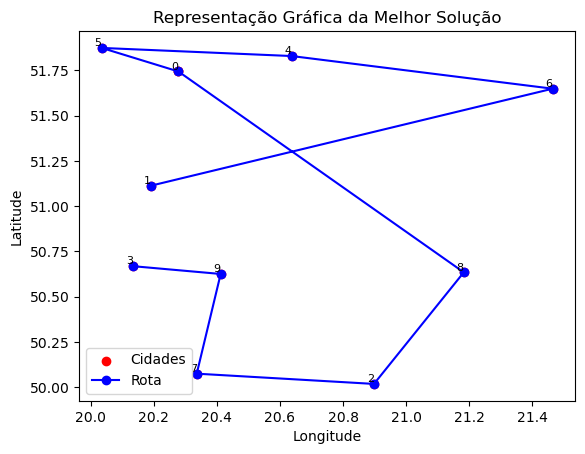

In [136]:
# Função para fazer plot das cidades e da rota com a melhor solução:
def plot_solution(city_locations, solution):
    # Descompacta as coordenadas das cidades
    lats, lons = zip(*city_locations)
    
    # Adiciona a primeira cidade no final para fechar o ciclo
    lats += (lats[0],)
    lons += (lons[0],)
    
    # Plota as cidades
    plt.scatter(lons, lats, color='red', marker='o', label='Cidades')
    
    # Plota a rota
    plt.plot(np.take(lons, solution), np.take(lats, solution), linestyle='-', marker='o', color='blue', label='Rota')
    
    # Adiciona rótulos para as cidades
    for i, txt in enumerate(range(len(city_locations))):
        plt.annotate(txt, (lons[i], lats[i]), fontsize=8, ha='right', va='bottom')
    
    # Adiciona legendas e títulos
    plt.legend()
    plt.title('Representação Gráfica da Melhor Solução')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Exibe o gráfico
    plt.show()

# Exemplo de uso
plot_solution(city_locations, best_solution)

##### Pergunta 4.
O que acontece ao modelo se a atualização não for aleatória, mas passar a ser sempre aquela em que a distância é a maior? Este modelo tem melhores resultados?

In [137]:
def generate_neighbour_bigger_distance(solution, distances):
    """ Gera um vizinho a partir da troca da cidade com maior distância para a última cidade.
    
    Parâmetros: 
    - solution: lista com solução candidata (list)
    - distances: Matriz com distâncias entre as cidades
    
    Returns: Lista com cidades que resulta da troca da cidade com maior distância para a última cidade.
    """
    
    max_distance = -1
    max_distance_city = -1

    for idx in range(len(solution)):
        new_distance = distances[solution[idx]][solution[-1]]
        if new_distance > max_distance:
            max_distance = new_distance
            max_distance_city = idx

    # Gera a nova solução com a cidade escolhida na última posição
    neighbour = np.concatenate([solution[:max_distance_city], solution[max_distance_city+1:], [solution[max_distance_city]]])
    
    return neighbour

In [140]:
def simulated_annealing_bigger_distance(distances, initial_solution, initial_temperature, cooling_rate, num_iterations):
    """
    Executa várias experiências tendo em consideração várias temperaturas iniciais e taxas de arrefecimento.

    Parâmetros:
    - distances: Matriz de distâncias entre as cidades.
    - initial_solution: Solução candidata inicial. (list)
    - initial_temperatures: Lista de temperaturas iniciais a serem testadas. (list)
    - cooling_rates: Lista de taxas de arrefecimento a serem testadas. (list)
    - num_iterations: Número total de iterações. (int)

    Returns: Lista com os resultados das experiências
    """
    current_solution = solucao_candidata
    best_solution = current_solution
    temperature = initial_temperature

    for iteration in range(num_iterations):
        neighbour_solution = generate_neighbour_bigger_distance(current_solution, distances)
        current_cost = objective_function(distances, current_solution)
        neighbour_cost = objective_function(distances, neighbour_solution)

        if neighbour_cost < current_cost or np.random.rand() < np.exp((current_cost - neighbour_cost) / temperature):
            current_solution = neighbour_solution

        if neighbour_cost < objective_function(distances, best_solution):
            best_solution = neighbour_solution

        temperature *= cooling_rate

    return best_solution

In [141]:
# Exemplo de uso
num_cities = 10
start_lat, start_lon = 50, 20
max_delta = 2

city_locations = [give_me_coordinates(start_lat, start_lon, max_delta) for _ in range(num_cities)]
distances = [[give_me_distance(city_locations[i], city_locations[j]) for j in range(num_cities)] for i in range(num_cities)]

initial_solution = solucao_candidata_fixa
initial_temperature = 1000.0
cooling_rate = 0.95
num_iterations = 20000

best_solution = simulated_annealing_bigger_distance(distances, initial_solution, initial_temperature, cooling_rate, num_iterations)
best_distance = objective_function(distances, best_solution)

print("Melhor solução:", best_solution)
print("Distância da melhor solução:", best_distance)

Melhor solução: [1 8 2 0 6 5 3 4 7 9]
Distância da melhor solução: 779.8160917309866


#### Resposta: 
À semelhança da escolha da temperatura inicial e taxa de arrefecimento, a escolha da estratégia de vizinhança tem impacto no desempenho do algoritmo Simulated Annealing.  
Como podemos ver no exemplo em cima, a solução dada tem uma distância maior dos que as estratégias anteriores onde usamos a aleatoriedade para escolher o vizinho, o que reflete uma pior performance do algoritmo.
Com estes resultados, podemos concluir que escolher o vizinho limitando a alteração de uma cidade pela distância maior afeta a capacidade do algoritmo procurar ótimos globais, limitando-o à procura de ótimos locais. Ou seja, os resultados podem não ser tão bons quanto seriam se procurássemos mais amplamente a solução. 